# 13주차 과제: CNN 활용

# 설정

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**패션 MNIST 로딩**

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


## 베이스라인 합성곱 신경망

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
np.array(history.history['val_accuracy']).max()

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7253 - accuracy: 0.7471 - val_loss: 0.3752 - val_accuracy: 0.8640
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4280 - accuracy: 0.8563 - val_loss: 0.3402 - val_accuracy: 0.8820
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3645 - accuracy: 0.8775 - val_loss: 0.3009 - val_accuracy: 0.8908
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3321 - accuracy: 0.8898 - val_loss: 0.2869 - val_accuracy: 0.8980
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3050 - accuracy: 0.8946 - val_loss: 0.2916 - val_accuracy: 0.8984
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2878 - accuracy: 0.9011 - val_loss: 0.2905 - val_accuracy: 0.8986
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2855 - accuracy: 0.9032 - val_loss: 0.2926 - val_ac

0.906000018119812

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

## Q1: 위 모델을 Functional API로 작성해 보시오.

In [ ]:
from tensorflow.keras import layers
from functools import partial

In [ ]:
# 코드 작성 영역

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

inputs = keras.Input(shape=(28,28,64))
con = DefaultConv2D(filters=64, input_shape=[28, 28, 1])
x = con(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=256)(x)
x = DefaultConv2D(filters=256)(x)
x = keras.layers.MaxPooling2D(pool_size=1)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(units=10, activation='softmax')(x)

model01 = keras.Model(inputs=inputs, outputs=outputs, name="model01")

model01.summary()

Model: "model01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 64)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 256)         2951

## Q2: 위 모델의 구조를 변경하여 검증 정확도가 좀더 높은 모델을 찾아 보시오.

Sequential API 기반으로 하시오.

힌트
- Conv2D, MaxPooling2D 갯수를 더 늘려보기
- 각 층의 필터 갯수
- 입력층 이후 최초 합성곱층의 커널 사이즈 변경
- 등

### 1) 추가 코드 

```
DefaultConv2D(filters=512),
DefaultConv2D(filters=512),
keras.layers.MaxPooling2D(pool_size=2)
```



In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
np.array(history.history['val_accuracy']).max()

Epoch 1/10
1719/1719 [==============================] - 19s 11ms/step - loss: 2.2758 - accuracy: 0.1171 - val_loss: 1.3488 - val_accuracy: 0.4752
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8181 - accuracy: 0.6914 - val_loss: 0.5011 - val_accuracy: 0.8290
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4954 - accuracy: 0.8332 - val_loss: 0.3844 - val_accuracy: 0.8608
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4270 - accuracy: 0.8575 - val_loss: 0.3439 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3838 - accuracy: 0.8707 - val_loss: 0.3443 - val_accuracy: 0.8764
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3631 - accuracy: 0.8789 - val_loss: 0.3193 - val_accuracy: 0.8822
Epoch 7/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3347 - accuracy: 0.8866 - val_loss: 0.3326 -

0.8888000249862671

### 2) 수정 코드 

```
AddConv2D = partial(keras.layers.Conv2D,
                        kernel_size=1, activation='relu', padding="SAME")

AddConv2D(filters=128),
AddConv2D(filters=128)
```



In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

AddConv2D = partial(keras.layers.Conv2D,
                        kernel_size=1, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    AddConv2D(filters=128),
    AddConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
np.array(history.history['val_accuracy']).max()

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6833 - accuracy: 0.7616 - val_loss: 0.4005 - val_accuracy: 0.8538
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4109 - accuracy: 0.8633 - val_loss: 0.3222 - val_accuracy: 0.8772
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3513 - accuracy: 0.8839 - val_loss: 0.3090 - val_accuracy: 0.8924
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3199 - accuracy: 0.8925 - val_loss: 0.2802 - val_accuracy: 0.8976
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2944 - accuracy: 0.8987 - val_loss: 0.2938 - val_accuracy: 0.8968
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2737 - accuracy: 0.9085 - val_loss: 0.2581 - val_accuracy: 0.9072
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2638 - accuracy: 0.9097 - val_loss: 0.2782 - val_ac

0.9100000262260437

### 3) 추가 및 수정 코드

```
AddConv2D = partial(keras.layers.Conv2D,
                        kernel_size=1, activation='relu', padding="SAME")
                        
AddConv2D(filters=128),
AddConv2D(filters=128),

## ... 생략 ...

DefaultConv2D(filters=512),
keras.layers.MaxPooling2D(pool_size=2),
```

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

AddConv2D = partial(keras.layers.Conv2D,
                        kernel_size=1, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    AddConv2D(filters=128),
    AddConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=512),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
np.array(history.history['val_accuracy']).max()

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7102 - accuracy: 0.7485 - val_loss: 0.3846 - val_accuracy: 0.8676
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4108 - accuracy: 0.8639 - val_loss: 0.3302 - val_accuracy: 0.8826
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3477 - accuracy: 0.8825 - val_loss: 0.2877 - val_accuracy: 0.8948
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3066 - accuracy: 0.8966 - val_loss: 0.3043 - val_accuracy: 0.8930
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2861 - accuracy: 0.9029 - val_loss: 0.2851 - val_accuracy: 0.9034
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2647 - accuracy: 0.9108 - val_loss: 0.2991 - val_accuracy: 0.8966
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2545 - accuracy: 0.9120 - val_loss: 0.2881 - val_ac

0.9046000242233276

### val_accuracy 비교

Origin : 0.906000018119812

1) 0.8888000249862671

2) 0.9100000262260437

3) 0.9046000242233276

# 저자 노트북의 ResNet-34 구현을 이용해 보자

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

## Q3: 저자의 ResNet-34 모델을 수정하여 패션 MNIST 데이터를 도전하여 최고 성능을 얻을 수 있도록 튜닝해보자.

목표
- 베이스라인 합성곱 신경망의 성능 뛰어 넘기
- Q2의 결과물을 뛰어 넘기

힌트
- Sequential API()의 첫 층의 ``input_shape`` 수정 필요
- 패션 MNIST는 이미지가 28X28이기 때문에  입력층 직후의 합성곱층-최대풀링의 변화 필요
    - 스트라이드를 하지 않거나
    - 최대 풀링 제거 하거나
- 모델 수정시 ``model.summary()``를 관찰하여 잔차 유닛 층에서 특성맵이 1x1은 되지 않도록 주의 하자.

In [ ]:
# 코드 작성 영역
#
# model 생성

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 28, 28, 64)        3136      
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 14, 14, 64)        74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 14, 14, 64)        74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 14, 14, 64)       

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
np.array(history.history['val_accuracy']).max()

Epoch 1/10
1719/1719 [==============================] - 71s 41ms/step - loss: 0.4449 - accuracy: 0.8436 - val_loss: 0.3249 - val_accuracy: 0.8800
Epoch 2/10
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2899 - accuracy: 0.8948 - val_loss: 0.3186 - val_accuracy: 0.8804
Epoch 3/10
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2558 - accuracy: 0.9078 - val_loss: 0.3349 - val_accuracy: 0.8828
Epoch 4/10
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2307 - accuracy: 0.9172 - val_loss: 0.2348 - val_accuracy: 0.9140
Epoch 5/10
1719/1719 [==============================] - 70s 41ms/step - loss: 0.1983 - accuracy: 0.9272 - val_loss: 0.2227 - val_accuracy: 0.9118
Epoch 6/10
1719/1719 [==============================] - 70s 40ms/step - loss: 0.1755 - accuracy: 0.9342 - val_loss: 0.2286 - val_accuracy: 0.9166
Epoch 7/10
1719/1719 [==============================] - 70s 41ms/step - loss: 0.1523 - accuracy: 0.9436 - val_loss: 0.2233 -

0.9243999719619751

# 전이 학습

저자 노트북 14_deep_computer_vision_with_cnns.ipyb의 "Pretrained Models for Transfer Learning" 참고

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("stanford_dogs", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQAH2ZL/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQAH2ZL/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].names
class_names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

12000

In [ ]:
dataset

{'test': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

## Q4-1: ``tfds.load``를 통해 테스트, 검증, 훈련셋 로딩
- test_set_raw: "test" 스플릿 전체
- valid_set_raw: "train" 스플릿의 20%
- train_set_raw: "train" 스플릿의 80%

In [ ]:
## 코딩 영역
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "stanford_dogs",
    split=["train", "train[:20%]", "train[20%:]"],
    as_supervised=True)

In [ ]:
train_set_size, valid_set_size, test_set_size = len(train_set_raw), len(valid_set_raw), len(test_set_raw)

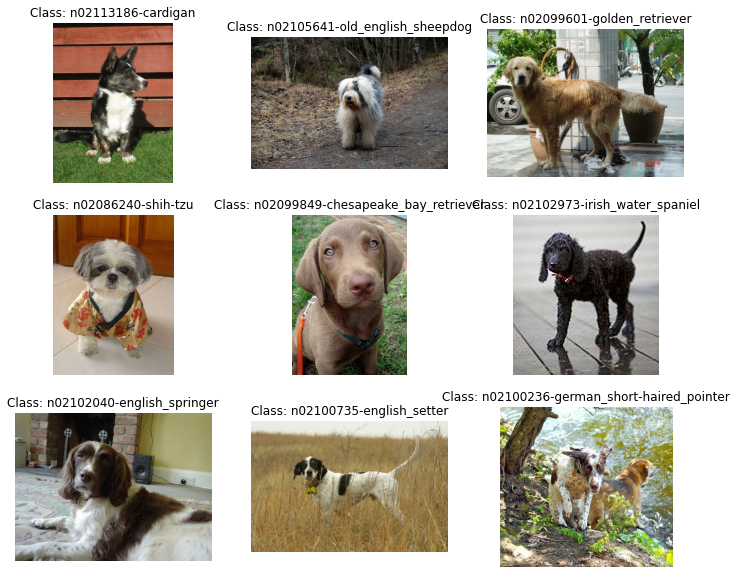

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

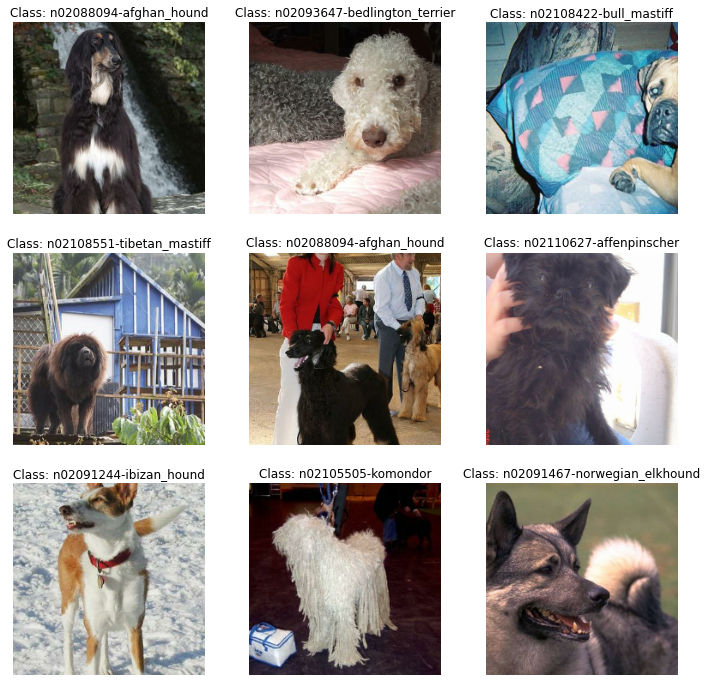

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

## Q4-2: 사전 훈련 모델 로딩 및 워밍업

Xception 모델 로딩 및 최상위 층 수정
- ``base_model``
    - Xception 로딩
    - ``include_top=False``: 최상위 층 제거
- ``model``
    - ``GlobalAveragePooling2D()`` 추가하고 base_model.output을 연결
    - ``Dense`` 추가
        - 소프트맥스 활성화
    - 모델의 입력: ``base_model.input``
    - 모델의 출력: 추가한 ``Dense``층의 출력

In [ ]:
## 코딩 영역
## model을 생성할 것

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


웜업(Warm-up)
- 사전 학습 층은 훈련 불가로 설정
- 저자 노트북과 동일한 세팅으로 학습하되
- 수정
    - ``steps_per_epoch`` 에 훈련 데이터셋 크기 지정
    - ``validation_steps``에 검증 데이터셋 크기 지정

In [ ]:
## 코딩 영역

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.2 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
300/300 [==============================] - 30s 99ms/step - loss: 1.1448 - accuracy: 0.7618 - val_loss: 0.9938 - val_accuracy: 0.8033
Epoch 2/5
300/300 [==============================] - 29s 97ms/step - loss: 0.4659 - accuracy: 0.8777 - val_loss: 0.7744 - val_accuracy: 0.8271
Epoch 3/5
300/300 [==============================] - 29s 97ms/step - loss: 0.3410 - accuracy: 0.8977 - val_loss: 0.7387 - val_accuracy: 0.8263
Epoch 4/5
300/300 [==============================] - 29s 97ms/step - loss: 0.2961 - accuracy: 0.9064 - val_loss: 0.6885 - val_accuracy: 0.8350
Epoch 5/5
300/300 [==============================] - 29s 97ms/step - loss: 0.2648 - accuracy: 0.9140 - val_loss: 0.6694 - val_accuracy: 0.8363


## Q 4-3: 파인튜닝

전체 네트워크 학습
- 사전 학습 층을 훈련 가능하게 변경하고 진행
- 저자 노트북과 유사하게 진행
- 참고
    - ``tf_flowers`` 데이터와 달리 검증 성능이 크게 개선되지는 않음
    - 데이터 증강 부분을 조사하여 성능 개선을 추구해보자.

In [ ]:
## 코딩 영역
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.2 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
  2/300 [..............................] - ETA: 1:38 - loss: 0.2030 - accuracy: 0.9375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0881s vs `on_train_batch_end` time: 0.2889s). Check your callbacks.


300/300 [==============================] - 120s 400ms/step - loss: 0.4345 - accuracy: 0.8657 - val_loss: 0.8519 - val_accuracy: 0.7596
Epoch 2/5
300/300 [==============================] - 119s 398ms/step - loss: 0.2302 - accuracy: 0.9274 - val_loss: 0.7928 - val_accuracy: 0.7783
Epoch 3/5
300/300 [==============================] - 119s 398ms/step - loss: 0.1292 - accuracy: 0.9625 - val_loss: 0.7554 - val_accuracy: 0.7942
Epoch 4/5
300/300 [==============================] - 119s 398ms/step - loss: 0.0948 - accuracy: 0.9730 - val_loss: 0.7146 - val_accuracy: 0.8075
Epoch 5/5
300/300 [==============================] - 119s 398ms/step - loss: 0.0720 - accuracy: 0.9822 - val_loss: 0.7122 - val_accuracy: 0.8112
